In [29]:
#Functionalized Data to Midi - Arbitrary Set Time

import matplotlib.pyplot as plt
import numpy as np
import random as rand

from midiutil import MIDIFile

%matplotlib inline

In [30]:
def set_midi_notes_for_mode(start_note, octaves, mode):
    #Returns a list of Diatonic Notes in the Mode
    #Returns a 2nd list of Accidental Notes not in the Mode
    
    modes = {
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2]
    }
    
    diatonics = []
    accidentals = []
    
    for octave in range(octaves):
        note = start_note + (12*octave) #first octave = 0, 2nd=1, etc
        
        for step in modes[mode]:
            diatonics.append(note)
            note = note + step
    last_note = start_note + (octaves*12) #sets last note
    diatonics.append(last_note) #there must be a better way to do this
    
    for i in range(octaves*12): #in range of all semitones
        note = start_note + i
        
        if note not in diatonics:
            accidentals.append(note)
            
    return diatonics, accidentals

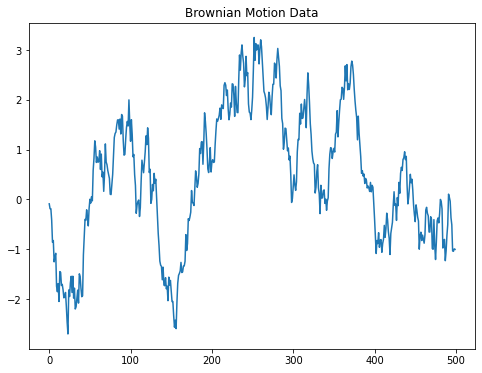

In [31]:
#Making some fancy data

from math import sqrt
from scipy.stats import norm

def brownian(x0, n, dt, delta, out=None):
    '''Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.'''
    
    
    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

# The Wiener process parameter.
delta = 2
# Total time.
T = 10.0
# Number of steps.
N = 500
# Time step size
dt = T/N
data = brownian(0, N, dt, delta)

fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_title('Brownian Motion Data')
ax.plot(data)

[60, 62, 64, 65, 67, 69, 71, 72, 74, 76, 77, 79, 81, 83, 84, 86, 88, 89, 91, 93, 95, 96]
New Data Length: 100


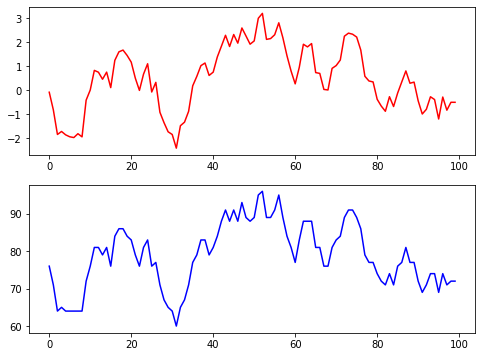

In [32]:
#Turn this data into Diatonic Midi

#Get Midi Notes to Use
start_note = 60 #Middle C
octaves = 3 #3octave span
mode = 'ionian'
diatonics, accidentals = set_midi_notes_for_mode(start_note, octaves, mode)
print(diatonics)

#Decide on sample amount from Data (or range), then map to diatonic Index
target_n = 100 #CHANGE THIS
step = int(len(data)/target_n)

data = data[0::step]
print('New Data Length:', len(data))

nout = np.interp(data, (data.min(), data.max()), (0, len(diatonics)-1))

out = np.zeros((2, len(nout))) #Set official out array, data:midi

for i in range(len(nout)):
    s = int(np.round(nout[i]))
    out[0,i] = data[i]
    out[1,i] = diatonics[s]

fig, ax =plt.subplots(2, figsize=(8, 6))
ax[0].plot(out[0], 'r') #Data
ax[1].plot(out[1], 'b') #Midi Map

In [33]:
#What we just did as a function

def Map_Data_to_MidiNotes_InMode(data, midilist, target_n):
    #Takes data and forces it upon a list of midi notes
    
    step = int(len(data)/target_n)
    data = data[0::step]
    nout = np.interp(data, (data.min(), data.max()), (0, len(midilist)-1))
    out = np.zeros((2, len(nout))) #Set official out array, data:midi

    for i in range(len(nout)):
        s = int(np.round(nout[i]))
        out[0,i] = data[i]
        out[1,i] = midilist[s]
        
    return out    

In [41]:
#Get Bpm and Note Duration

bpm = 140 #140 beats per minute

print('BeatsPerMin: ', bpm)
bps = bpm/60.
print('BeatsPerSec: ', bps)
spb = 1/bps
print('SecondsPerBeat:', spb)
print('Length of 1 Bar: ', spb*4)

note_duration = 960 #In ticks, 960 ticks per QuarterNote
#Note duration is considered the dt, a later example will have a seperate duration

def make_basic_diatonic_midifile(bpm, note_duration, midi_data, outfile_name):
    
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = 0
    
    mymidi = MIDIFile(1, eventtime_is_ticks=True)
    mymidi.addTempo(track, miditime, bpm)
    
    
    #Some calculations to approximate length in seconds
    # qnps = 1/(bpm/60.)*4 #quarter per sec
    spq = 1/(bpm/60.)
    note_time = note_duration / 960.
    tot_notetime = spq*note_time
    print('File Length:', len(midi_data)*(tot_notetime), 'seconds')
    
    for note in range(len(midi_data)):
        mymidi.addNote(track, channel, int(midi_data[note]), miditime, note_duration, velocity)
        miditime += note_duration
    
    with open("MidiFiles/{}.mid".format(outfile_name), "wb") as output_file:
        mymidi.writeFile(output_file)
        

BeatsPerMin:  140
BeatsPerSec:  2.3333333333333335
SecondsPerBeat: 0.42857142857142855
Length of 1 Bar:  1.7142857142857142


In [42]:
#Putting it all together. 

#Step 1 - Midi Notes
start_note = 60 #Middle C
octaves = 3 #3octave span
mode = 'ionian'
diatonics, accidentals = set_midi_notes_for_mode(start_note, octaves, mode)

#Step 2 - Make Data
delta = 2 # The Wiener process parameter.
T = 10.0 #Total time. arbitrary in this case
N = 500
dt = T/N
data = brownian(0, N, dt, delta)

#Step 3 - Sample and Interp
target_n = 100
midi_notes = Map_Data_to_MidiNotes_InMode(data, diatonics, target_n)

#Step 4 - Profit
bpm = 120
note_duration = 960 #in ticks
outfile_name = 'BrownianSounds2.0'
make_basic_diatonic_midifile(bpm, note_duration, midi_notes[1], outfile_name)


File Length: 50.0 seconds
